# Australian Internet Vacancy Trends Analysisn (2019-2025)
This notebook processes and visualizes vacancy data by occupation (ANZSCO) across Australia.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the historical vacancy data from CSV
df = pd.read_csv('data/internet_vacancies.csv')

# Identify columns representing dates (formatted as 'Month-Year')
date_cols = [col for col in df.columns if '-' in col]

df.head(5)

,Level,State,region_name,region_code,region_level,ANZSCO_CODE,ANZSCO_TITLE,Jan-19,Feb-19,Mar-19,...,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25,Aug-25,Sep-25,Oct-25,Nov-25
0,1,NSW,Greater Sydney,1GSYD,GCCSA,0,Greater Sydney TOTAL,50206,50455,57031,...,"40,594","46,203","44,118","44,332","43,010","44,887","44,432","45,823","45,955","44,683"
1,2,NSW,Greater Sydney,1GSYD,GCCSA,1,MANAGERS,8144,8311,9366,...,"6,075","6,957","6,676","6,761","6,546","6,738","6,687","6,809","6,676","6,347"
2,3,NSW,Greater Sydney,1GSYD,GCCSA,11,"Chief Executives, Managing Directors & Legisla...",223,221,249,...,231,256,245,244,248,259,261,256,243,245
3,3,NSW,Greater Sydney,1GSYD,GCCSA,12,Farmers and Farm Managers,7,8,10,...,8,11,12,12,9,9,11,10,10,7
4,3,NSW,Greater Sydney,1GSYD,GCCSA,14,"Hospitality, Retail and Service Managers",1759,1794,1980,...,"1,548","1,810","1,699","1,739","1,638","1,724","1,726","1,809","1,791","1,684"


## 2. Occupation Code Mapping

In [2]:
# Create a unique mapping between ANZSCO codes and titles for easy lookup
mapping = (
    df[["ANZSCO_CODE", "ANZSCO_TITLE"]]
    .drop_duplicates()
)
mapping.head(20)

,ANZSCO_CODE,ANZSCO_TITLE
0,0,Greater Sydney TOTAL
1,1,MANAGERS
2,11,"Chief Executives, Managing Directors & Legisla..."
3,12,Farmers and Farm Managers
4,14,"Hospitality, Retail and Service Managers"
5,1A,Corporate Managers
6,1B,"Construction, Production and Distribution Mana..."
7,1C,"Health, Education, ICT and Other Managers"
8,2,PROFESSIONALS
9,21,Arts and Media Professionals


**ANZSCO_CODE for ICT professionals is "26"**

## 3. Data Cleaning

In [3]:
# Remove commas from numeric strings and convert date columns to integers
for date_col in date_cols:
    if not pd.api.types.is_integer_dtype(df[date_col]):
        df[date_col] = (
        df[date_col]
          .str.replace(",", "", regex=False)
          .astype(int)
)

## 4. National Data Aggregation

In [4]:
# Group data by occupation code and sum values across all states to get national totals
aus_df = (
    df
    .groupby(["ANZSCO_CODE"], as_index=False)[date_cols]
    .sum()
)

# Re-attach occupation titles to the aggregated data using our previous mapping
title_counts = mapping.groupby("ANZSCO_CODE")["ANZSCO_TITLE"].nunique()
unique_codes = title_counts[title_counts == 1].index
valid_lookup = mapping[mapping["ANZSCO_CODE"].isin(unique_codes)].set_index("ANZSCO_CODE")["ANZSCO_TITLE"]

aus_df["ANZSCO_TITLE"] = aus_df["ANZSCO_CODE"].map(valid_lookup)
aus_df.loc[aus_df["ANZSCO_CODE"] == "0", "ANZSCO_TITLE"] = "TOTAL"

# Reorder columns to put Title at the front
col = "ANZSCO_TITLE"
aus_df = aus_df[[col] + [c for c in aus_df.columns if c != col]]

aus_df.head()

,ANZSCO_TITLE,ANZSCO_CODE,Jan-19,Feb-19,Mar-19,Apr-19,May-19,Jun-19,Jul-19,Aug-19,...,Feb-25,Mar-25,Apr-25,May-25,Jun-25,Jul-25,Aug-25,Sep-25,Oct-25,Nov-25
0,TOTAL,0,165363,165429,185974,174667,176608,169588,177768,175656,...,192841,215338,204042,206099,201701,210416,208051,214332,215499,209716
1,MANAGERS,1,21384,21744,24286,22888,22780,21810,22467,22145,...,23260,26155,24934,25301,24725,25513,25059,25396,25140,23969
2,"Chief Executives, Managing Directors & Legisla...",11,738,733,807,804,845,811,840,803,...,956,1021,1011,1051,1047,1080,1053,1044,1040,1005
3,Farmers and Farm Managers,12,109,122,149,132,127,123,136,142,...,173,193,187,197,187,199,198,200,190,178
4,"Hospitality, Retail and Service Managers",14,5142,5273,5841,5344,5223,4974,5070,5149,...,7159,8012,7456,7548,7365,7613,7531,7626,7582,7097


## 5. Visualizing Trends

In [21]:
import textwrap

def plot_vacancy_trends(code, code_alt=None, save=False):

    title = aus_df.loc[aus_df["ANZSCO_CODE"] == code, "ANZSCO_TITLE"].item()
    full_title = title
    vline_covid = pd.to_datetime("2020-3-01")
    vline_gpt = pd.to_datetime("2022-11-30")
    
    months = [c for c in aus_df.columns if "-" in c]
    months_dt = pd.to_datetime(date_cols, format="%b-%y")

    values = aus_df.loc[aus_df["ANZSCO_CODE"] == code, months].iloc[0].tolist()
    
    plt.plot(months_dt, values, label=title)

    if code_alt:
        title_alt = aus_df.loc[aus_df["ANZSCO_CODE"] == code_alt, "ANZSCO_TITLE"].item()
        full_title = f"{title} vs {title_alt}"
        values_alt = aus_df.loc[aus_df["ANZSCO_CODE"] == code_alt, months].iloc[0].tolist()
        plt.plot(months_dt, values_alt, color="brown", label=title_alt)

    # wrap the tile if too long
    wrapped_title = "\n".join(
        textwrap.wrap(f"{full_title} Vacancies over time (Australia)", width=50)
        )

    plt.axvline(vline_covid, linestyle=":", linewidth=1, label="COVID-19", color="red")
    plt.axvline(vline_gpt, linestyle=":", linewidth=1, label="GPT-3.5", color="green")
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("Vacancies")
    
    plt.title(wrapped_title)
    plt.tight_layout()

    if save:
        plt.savefig(f'outputs/images/{full_title}.png') 
    plt.show()


## Example Usage

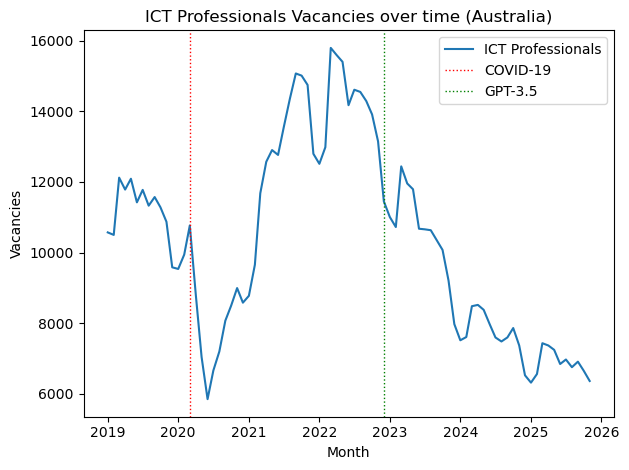

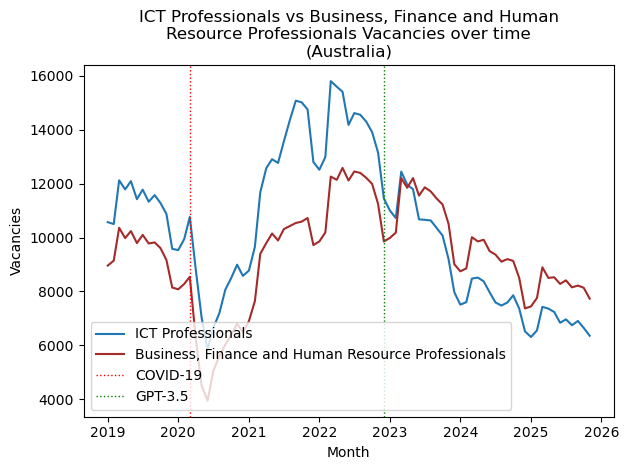

In [22]:
plot_vacancy_trends("26", save=True) # ICT
plot_vacancy_trends("26", "2A", save=True) # ICT vs Business